# Sentinel 2, Landsat 8, PRISMA coincident targeting

This notebook uses the S2 and L8 trajectories to determine the times at which images will be taken of targets.

## Targets

In [64]:
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import shapely
from datetime import timedelta
import datetime as dt
import itertools as it
import numpy as np

gpd.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default

In [5]:
# read target data
# polygons
gdf_targets = gpd.read_file('targets/rgi60_targets.shp')
# centre lat-lons & names
df_targets_lls = pd.read_excel('targets/target_coordinates.xlsx', 
                               engine='openpyxl')
# convert this to a geodataframe
df_targets_lls['geometry'] = df_targets_lls.apply(lambda row: shapely.geometry.Point(row.lon, row.lat), axis=1)
gdf_targets_lls = gpd.GeoDataFrame(df_targets_lls, crs='EPSG:4326')

In [6]:
gdf_targets_lls

,Name,lon,lat,strip length [km],Bbox,Unnamed: 5,Unnamed: 6,Unnamed: 7,geometry
0,Peyto,-116.550000,51.650000,30,NaN,NaN,NaN,NaN,POINT (-116.55000 51.65000)
1,Columbia,-117.350000,52.152000,30,52.27587,-117.56945,52.01726,-117.14901,POINT (-117.35000 52.15200)
2,Klinaklini,-125.970000,51.500000,60,51.65126,-126.18150,51.31000,-125.74450,POINT (-125.97000 51.50000)
3,Place,-122.603491,50.418547,30,NaN,NaN,NaN,NaN,POINT (-122.60349 50.41855)


In [8]:
# some targets are broken up into multiple polygons
# merge these
targets = (gdf_targets
            .set_crs(epsg=4326) # set correct crs
            .to_crs(epsg=3005) # to local projection
            .buffer(1000) # buffer to overlap close polys
            .unary_union # merge overlapping
            .buffer(0)) # buffer to remove weird shapes
gdf_targets = gpd.GeoDataFrame({'geometry':targets}, crs='EPSG:3005')
gdf_targets = gdf_targets.to_crs(epsg=4326)

# polygons don't have names, provide these from an xl sheet
gdf_targets = gpd.sjoin(gdf_targets, gdf_targets_lls). drop('index_right', axis=1)
gdf_targets

,geometry,Name,lon,lat,strip length [km],Bbox,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"POLYGON ((-116.62462 51.66484, -116.62458 51.6...",Peyto,-116.550000,51.650000,30,NaN,NaN,NaN,NaN
1,"POLYGON ((-117.59363 52.15214, -117.59395 52.1...",Columbia,-117.350000,52.152000,30,52.27587,-117.56945,52.01726,-117.14901
2,"POLYGON ((-122.66700 50.42381, -122.66641 50.4...",Place,-122.603491,50.418547,30,NaN,NaN,NaN,NaN
3,"POLYGON ((-126.19740 51.44455, -126.19731 51.4...",Klinaklini,-125.970000,51.500000,60,51.65126,-126.18150,51.31000,-125.74450


<AxesSubplot:>

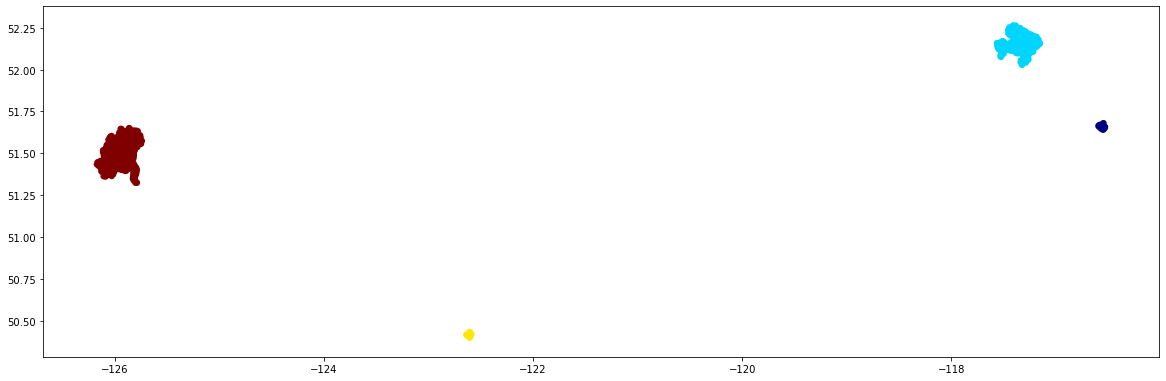

In [9]:
# check we've nicely separated the 4 targets
plt.figure(figsize=(20,20))
gdf_targets.plot(ax=plt.gca(), column=gdf_targets.index.values, cmap='jet')

## Sentinel 2

Get .kml URLs for recent and near future trajectories for Sentinel 2A and 2B from:

https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/acquisition-plans

In [10]:
s2a_kml_url = 'https://sentinels.copernicus.eu/documents/247904/4584266/Sentinel-2A_MP_ACQ_KML_20210617T120000_20210705T150000.kml'
s2b_kml_url = 'https://sentinels.copernicus.eu/documents/247904/4584270/Sentinel-2B_ACQ_MP_KML_20210624T120000_20210712T150000.kml'

s2a_kml_fname = s2a_kml_url.split('/')[-1]
s2b_kml_fname = s2b_kml_url.split('/')[-1]

In [11]:
# download S2 recent and upcoming acquisitions
!wget $s2a_kml_url
!wget $s2b_kml_url

--2021-06-24 09:55:09--  https://sentinels.copernicus.eu/documents/247904/4584266/Sentinel-2A_MP_ACQ_KML_20210617T120000_20210705T150000.kml
Resolving sentinels.copernicus.eu (sentinels.copernicus.eu)... 193.105.125.90
Connecting to sentinels.copernicus.eu (sentinels.copernicus.eu)|193.105.125.90|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 1560442 (1.5M) [application/vnd.google-earth.kml+xml]
Saving to: ‘Sentinel-2A_MP_ACQ_KML_20210617T120000_20210705T150000.kml’

Sentinel-2A_MP_ACQ_ 100%[===================>]   1.49M   210KB/s    in 13s     

2021-06-24 09:55:24 (121 KB/s) - ‘Sentinel-2A_MP_ACQ_KML_20210617T120000_20210705T150000.kml’ saved [1560442/1560442]

--2021-06-24 09:55:24--  https://sentinels.copernicus.eu/documents/247904/4584270/Sentinel-2B_ACQ_MP_KML_20210624T120000_20210712T150000.kml
Resolving sentinels.copernicus.eu (sentinels.copernicus.eu)... 193.105.125.90
Connecting to sentinels.copernicus.eu (sentinels.copernicus.eu)|193.105.125.90|:4

In [12]:
# parse the Sentinel 2 planned acquisitions KML file
# inspired by
# https://gis.stackexchange.com/questions/376301/return-empty-dataframe-when-reading-kml-file-of-sentinel-1-acquisition-segments

def parse_kml(fp, satellite_name):
    gdf_list = []
    for layer in fiona.listlayers(fp):
        gdf = gpd.read_file(fp, driver='LIBKML', layer=layer)
        gdf_list.append(gdf)
        
    gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
    gdf['satellite'] = satellite_name
        
    return gdf


gdf_s2 = pd.concat([parse_kml(s2a_kml_fname, 's2a'), 
                    parse_kml(s2b_kml_fname, 's2b')])

In [13]:
# find acquisitions containing each target
gdf_within = gpd.sjoin(gdf_targets, gdf_s2, how='inner', op='within').reset_index()
gdf_within = gdf_within.drop_duplicates('index_right')
len(gdf_within)

18

<AxesSubplot:>

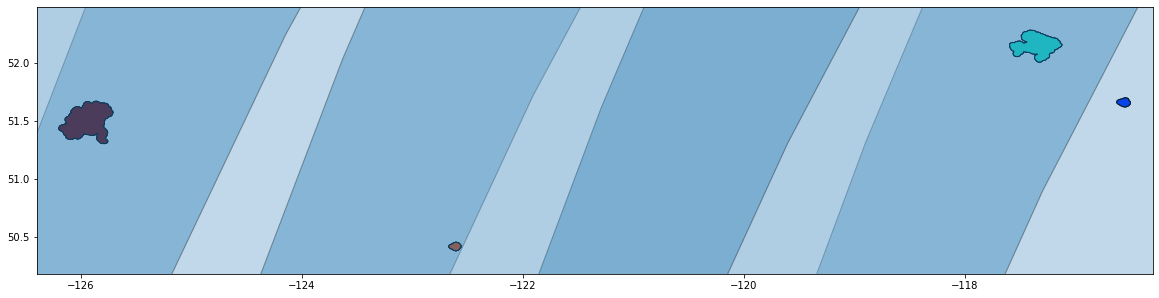

In [14]:
plt.figure(figsize=(20,20))

buffer = 0.2
xlim = ([gdf_within.total_bounds[0]-buffer,  gdf_within.total_bounds[2]+buffer])
ylim = ([gdf_within.total_bounds[1]-buffer,  gdf_within.total_bounds[3]+buffer])

plt.gca().set_xlim(xlim)
plt.gca().set_ylim(ylim)

gdf_within.plot(ax=plt.gca(), column=gdf_within.index.values, cmap='jet', edgecolor='k')
gdf_s2.loc[gdf_within.index_right].plot(ax=plt.gca(), edgecolor='k', alpha=0.1)

In [15]:
# convert columns to datetime if possible
for col in gdf_within:
    try:
        gdf_within[col] = pd.to_datetime(gdf_within[col])
    except:
        pass

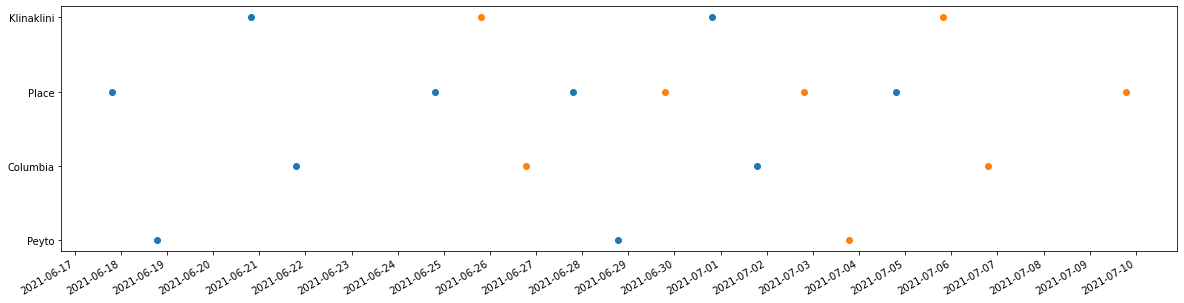

In [16]:
plt.figure(figsize=(20,5))

# plot S2A and S2B with different colours
for sat in gdf_within.satellite.unique():
    plt.scatter(gdf_within[gdf_within.satellite==sat].ObservationTimeStart, 
                gdf_within[gdf_within.satellite==sat]['Name_left'])

plt.gcf().autofmt_xdate()

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

In [17]:
# get the first occurrence of each OrbitRelative (analagous to L8 path)
df_s2acq = (gdf_s2[['satellite','OrbitRelative','ObservationTimeStart']]
            .sort_values('ObservationTimeStart')
            .drop_duplicates(['satellite','OrbitRelative']))
df_s2acq

,satellite,OrbitRelative,ObservationTimeStart
0,s2a,95,2021-06-17T12:36:52.628
5,s2a,96,2021-06-17T14:17:33.425
9,s2a,97,2021-06-17T15:58:58.315
11,s2a,98,2021-06-17T17:38:58.132
13,s2a,99,2021-06-17T19:19:05.298
...,...,...,...
438,s2b,118,2021-07-04T03:15:34.546
439,s2b,119,2021-07-04T04:56:51.588
441,s2b,120,2021-07-04T06:36:20.814
443,s2b,121,2021-07-04T08:15:58.053


## Landsat 8

Use the descending (daytime) path-row shapes from USGS to determine which path-row each target falls into.

Use the calendar on https://landsat.usgs.gov/landsat_acq#pendingAcquisition to find upcoming acquisitions for these path-rows.

Use the 16 day repeat to predict?

Can check passover times and altitudes using: https://www.heavens-above.com/PassSummary.aspx?satid=39084&lat=50.418547&lng=-122.603491&loc=Unnamed&alt=0&tz=PST&showall=t

In [18]:
# load path-rows
gdf_l8_pr = gpd.read_file('./L8_path_rows_descending_(daytime)/WRS2_descending.shp')

In [19]:
# join with target shapes
gdf_l8_within = gpd.sjoin(gdf_targets, gdf_l8_pr, op='within')

<AxesSubplot:>

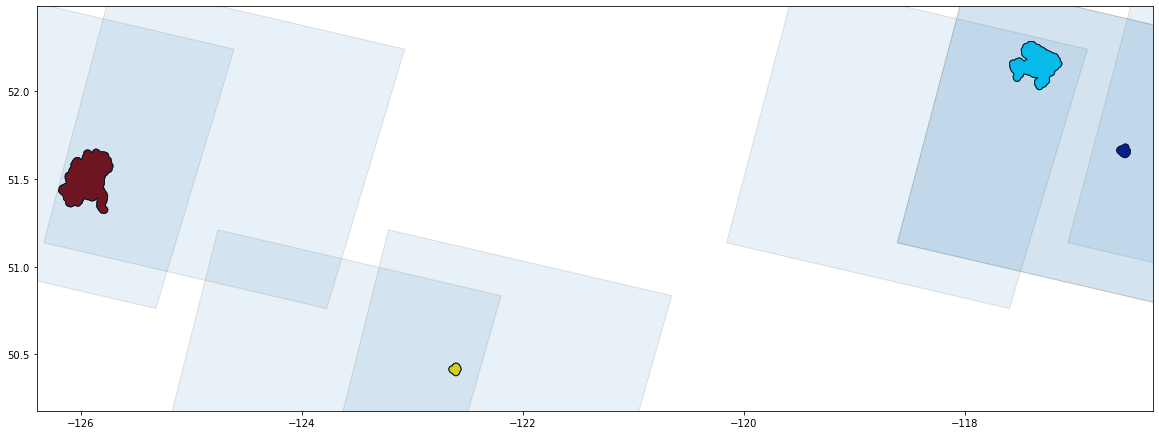

In [20]:
plt.figure(figsize=(20,20))

buffer = 0.2
xlim = ([gdf_l8_within.total_bounds[0]-buffer,  gdf_l8_within.total_bounds[2]+buffer])
ylim = ([gdf_l8_within.total_bounds[1]-buffer,  gdf_l8_within.total_bounds[3]+buffer])

plt.gca().set_xlim(xlim)
plt.gca().set_ylim(ylim)

gdf_l8_within.plot(ax=plt.gca(), column=gdf_l8_within.index.values, cmap='jet', edgecolor='k')
gdf_l8_pr.loc[gdf_l8_within.index_right].plot(ax=plt.gca(), edgecolor='k', alpha=0.1)

In [21]:
gdf_l8_within[['Name','PATH','ROW','ACQDayL8']]

,Name,PATH,ROW,ACQDayL8
0,Peyto,43,24,11
0,Peyto,44,24,2
1,Columbia,44,24,2
1,Columbia,45,24,9
2,Place,48,25,14
2,Place,47,25,7
3,Klinaklini,50,24,12
3,Klinaklini,49,24,5


In [22]:
# calculate repeat assuming 16 day cycle and a "day 1"
# set passover time as 4am UTC / 12pm PST
day1 = pd.to_datetime("4th Mar 2021")
gdf_l8_within['first_obs'] = gdf_l8_within.ACQDayL8.apply(lambda x: timedelta(days=int(x)) + day1 - timedelta(hours=4))

## PRISMA

Can get rough overpass times using 

- Columbia: 
    - https://www.heavens-above.com/PassSummary.aspx?satid=44072&lat=52.152000&lng=-117.350000&loc=Unnamed&alt=0&tz=GMT&showall=t
- Place: 
    - https://www.heavens-above.com/PassSummary.aspx?satid=44072&lat=50.418547&lng=-122.603491&loc=Unnamed&alt=0&tz=GMT&showall=t
- Klinaklini: 
    - https://www.heavens-above.com/PassSummary.aspx?satid=44072&lat=51.500000&lng=-125.970000&loc=Unnamed&alt=0&tz=GMT&showall=t
- Peyto: 
    - https://www.heavens-above.com/PassSummary.aspx?satid=44072&lat=51.650000&lng=-116.550000&loc=Unnamed&alt=0&tz=GMT&showall=t

Copy the tables from these webpages into a local excel file, with one tab per target.

Keep in mind the perigree height of PRISMA is 615km, so a 30km wide image subtends around 3deg, which should be included when filtering the PRISMA passover altitude to match the acquisition min/max inclination.

In [23]:
# calculate minimum passover altitude for viable acquisition
inclination_max = 21
img_width = 30
prisma_height = 600
prisma_img_angle = np.arctan(img_width / prisma_height) / np.pi * 180
altitude_min = 90 - inclination_max + prisma_img_angle
altitude_min

71.86240522611175

In [98]:
# load excel sheets
df_prisma_ls = []

for name in gdf_targets.Name:
    df_prisma_hold = pd.read_excel("PRISMA_passover_times.xls", 
                                   sheet_name=name, skiprows=1)
    df_prisma_hold["target"] = name
    df_prisma_ls += [df_prisma_hold]
    
df_prisma = pd.concat(df_prisma_ls, ignore_index=True)

# keep only daylight passovers
df_prisma = df_prisma[df_prisma["Unnamed: 11"]=='daylight']

# keep only relevant columns and rename
prisma_cols = {"Unnamed: 0":"date", 
               "Time.1":"time", 
               "Alt..1":"altitude", 
               "Az..1":"azimuth", 
               "target":"target"}
df_prisma = df_prisma[prisma_cols.keys()]
df_prisma = df_prisma.rename(columns=prisma_cols)

# combine date and time
year = 2021
df_prisma['datetime'] = ((df_prisma.date.astype(str) + str(year) + df_prisma.time.astype(str))
                         .apply(lambda t: dt.datetime.strptime(t, "%d %b%Y%H:%M:%S")))
df_prisma['datetime'] = pd.to_datetime(df_prisma['datetime'])

# get start and end of PRISMA acquisition dates
prisma_start = df_prisma.datetime.min().date()
prisma_end = df_prisma.datetime.max().date()

# convert altitude to numeric
df_prisma['altitude'] = df_prisma.altitude.str[:-1].astype(float)

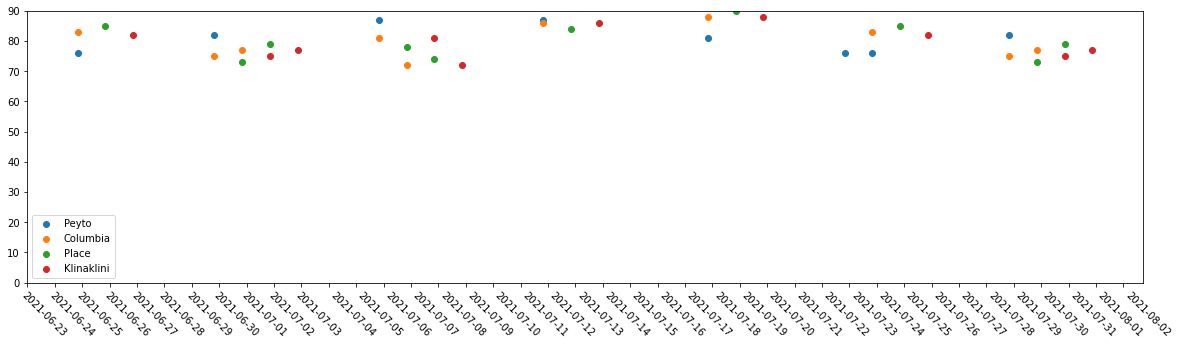

In [99]:
plt.figure(figsize=(20,5))

# plot S2A and S2B with different colours
for target in df_prisma.target.unique():
    df_plot = df_prisma[(df_prisma.target==target) & (df_prisma.altitude>=altitude_min)]
    plt.scatter(df_plot.datetime, df_plot.altitude, label=target)

plt.setp( plt.gca().xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().set_xlim([pd.to_datetime("2021/03/19"), pd.to_datetime("2021/04/19")])
plt.legend(); plt.gca().set_ylim([0,90]); plt.show()

## Targeting dates

In [68]:
# dataframe to hold passover times for each satellite/target combo
df_dates = pd.DataFrame(columns=pd.MultiIndex.from_product([gdf_targets.Name, ['s2a', 's2b', 'l8']], 
                                                           names=["target", "satellite"]), index=[0])

In [69]:
# functions to create S2 and L8 acquisition dates assuming fixed repeat times
def s2_acq_dates(target, sat):
    orbit_relatives = gdf_within[(gdf_within.Name_left==target) & (gdf_within.satellite==sat)]
    orbit_relatives = orbit_relatives.OrbitRelative.unique()
#     print(len(orbit_relatives))
    
    dates_ls = []
    
    for orbit_relative in orbit_relatives:
#         print(orbit_relative)
        first_obs = df_s2acq[(df_s2acq.satellite==sat) & (df_s2acq.OrbitRelative==orbit_relative)]
        first_obs = first_obs.ObservationTimeStart.values[0]
#         print(first_obs)
        
        dates_ls += [pd.Series(pd.date_range(first_obs, pd.to_datetime('15th Sept 2021'), freq='10D'))]
#         print(dates_ls)
        
    dates = pd.concat(dates_ls, ignore_index=True).sort_values().reset_index(drop=True)
    
    return dates

def l8_acq_dates(target):
    first_obss = gdf_l8_within[gdf_l8_within.Name==target].first_obs
    
    dates_ls = []
    for first_obs in first_obss:
        dates_ls += [pd.Series(pd.date_range(first_obs, pd.to_datetime('15th Sept 2021'), freq='16D'))]
        
    dates = pd.concat(dates_ls, ignore_index=True).sort_values().reset_index(drop=True)
    
    return dates

In [70]:
# convert date-like fields to datetime
for (target, sat) in df_dates.columns:
    if sat != 'l8':
        df_dates[target, sat].at[0] = s2_acq_dates(target, sat)
    if sat == 'l8':
        df_dates[target, sat].at[0] = l8_acq_dates(target)

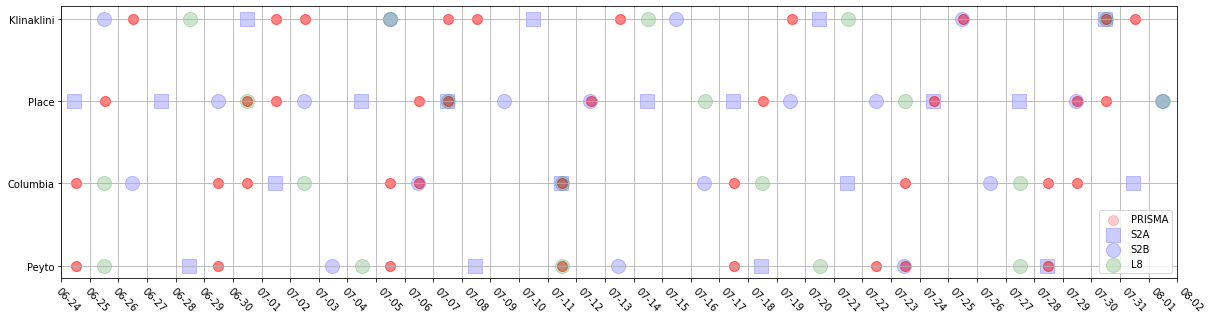

In [100]:
plt.figure(figsize=(20,5))

colours = {'s2a':'b', 's2b':'b', 'l8':'g'}

for i, (target, sat) in enumerate(df_dates.columns):
    # plot prisma passovers
    df_prisma_target = df_prisma[(df_prisma.target==target) & 
                                 (df_prisma.altitude>=altitude_min)]
    plt.scatter(df_prisma_target.datetime-dt.timedelta(hours=8), df_prisma_target.target,
                label=('PRISMA' if i == 0 else None), c='r', s=100, alpha=0.2)
    
    # plot other satellite passovers
    dates = df_dates[(target, sat)].iloc[0]
    plt.scatter(dates-dt.timedelta(hours=8), [target]*len(dates), c=colours.get(sat), s=200, alpha=0.2,
                marker='s' if sat == 's2a' else None,
                label=(sat.upper() if i < 3 else None))
    
plt.gca().set_xlim([prisma_start, prisma_end])
plt.setp( plt.gca().xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.legend()
plt.grid(True)

In [101]:
# create target-satellite vs. PST date table
df_acq = pd.DataFrame(columns=pd.MultiIndex.from_product([gdf_targets.Name,
                                                         ['s2', 'l8', 'PRISMA']]),
                     index=pd.date_range(prisma_start, end=prisma_end, freq='D'))

In [102]:
# functions to check for acquisitions on a given date for a given target (PST!)
def check_date_prisma(date, target):
    df_prisma_target = df_prisma[(df_prisma.target==target) & 
                                 (df_prisma.altitude>=altitude_min)]
    prisma_target_dates = df_prisma_target.datetime - dt.timedelta(hours=8)
    return (date.date() == prisma_target_dates.dt.date).any()

def check_date_L8(date, target):
    dates = df_dates[(target, 'l8')].iloc[0]  - dt.timedelta(hours=8)
    return (date.date() == dates.dt.date).any()

def check_date_S2(date, target):
    dates = pd.concat([df_dates[(target, 's2a')].iloc[0],
                       df_dates[(target, 's2b')].iloc[0]])  - dt.timedelta(hours=8)
    return (date.date() == dates.dt.date).any()

sat2func = {"PRISMA":check_date_prisma,
           "l8":check_date_L8,
           "s2":check_date_S2}

In [103]:
# find acquisition dates for all satellites
for (target, sat) in df_acq.columns:
    df_acq[(target, sat)] = (pd.Series(df_acq.index, index=df_acq.index)
                             .apply(lambda date: sat2func.get(sat)(date, target)))

In [104]:
# find which dates have a PRISMA acquisition AND (S2 OR L8)
for target in df_acq.columns.levels[0]:
    df_acq[(target, "acquire")] = df_acq[(target, "PRISMA")] & (df_acq[(target, "s2")] | df_acq[(target, "l8")])

In [106]:
# filter to the dates we have at least one coincident acquisition
df_acq = df_acq[df_acq.xs('acquire', axis=1, level=1, drop_level=False).any(axis=1)]

In [128]:
# get the dates to acquire for each target
for target in df_acq.columns.levels[0]:
    print("\n", target)
    dates = list(df_acq[df_acq[(target,"acquire")]][(target,"acquire")].index.date)
    for date in dates:
        print(date)


 Columbia
2021-07-06
2021-07-11

 Klinaklini
2021-07-25
2021-07-30

 Peyto
2021-07-11
2021-07-23
2021-07-28

 Place
2021-06-30
2021-07-07
2021-07-12
2021-07-24
2021-07-29


In [108]:
# show coordinates for ordering the acquisition
# set max cloud cover to 10%
# set max inclination to 21deg
# set max sun zenith angle to 70
# order at https://prisma.asi.it/
df_targets_lls

,Name,lon,lat,strip length [km],Bbox,Unnamed: 5,Unnamed: 6,Unnamed: 7,geometry
0,Peyto,-116.550000,51.650000,30,NaN,NaN,NaN,NaN,POINT (-116.55000 51.65000)
1,Columbia,-117.350000,52.152000,30,52.27587,-117.56945,52.01726,-117.14901,POINT (-117.35000 52.15200)
2,Klinaklini,-125.970000,51.500000,60,51.65126,-126.18150,51.31000,-125.74450,POINT (-125.97000 51.50000)
3,Place,-122.603491,50.418547,30,NaN,NaN,NaN,NaN,POINT (-122.60349 50.41855)
